# Modeling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings

## Outputs
* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [38]:
cwd= os.getcwd()

In [39]:
os.chdir('/workspace/Malaria-Detector-2022')
print("You set a new current directory")

You set a new current directory


In [40]:

work_dir = os.getcwd()
work_dir

'/workspace/Malaria-Detector-2022'

---

## Set input directories

Set train, validation and test paths

In [41]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [42]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [43]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['Parasitized', 'Uninfected']


## Set image shape

In [44]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Parasitized: 3950 images
* train - Uninfected: 3950 images
* validation - Parasitized: 564 images
* validation - Uninfected: 564 images
* test - Parasitized: 1129 images
* test - Uninfected: 1129 images




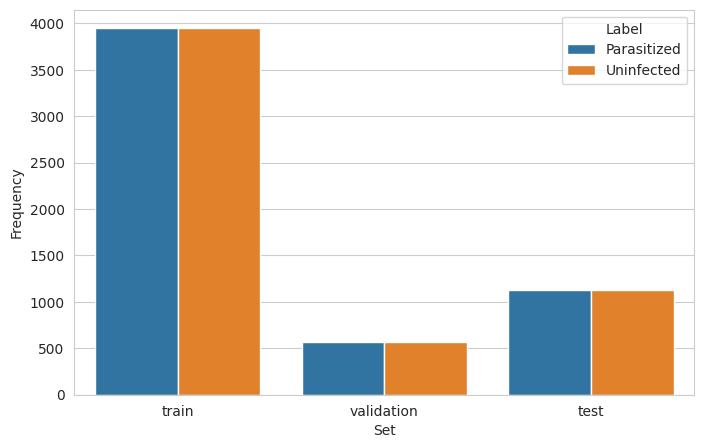

In [45]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Intiatize ImageDataGenerator

In [47]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

* ### Augment training image dataset

In [48]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment validation image dataset

In [49]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [50]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

## Plot augmented training image

(20, 129, 129, 3)


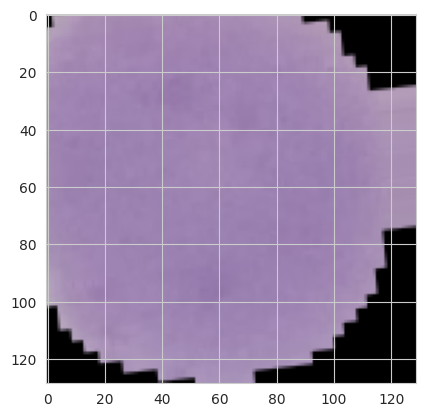

(20, 129, 129, 3)


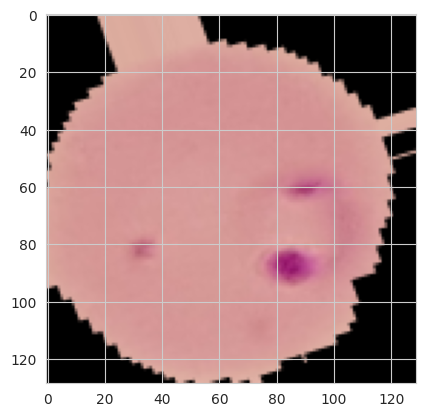

(20, 129, 129, 3)


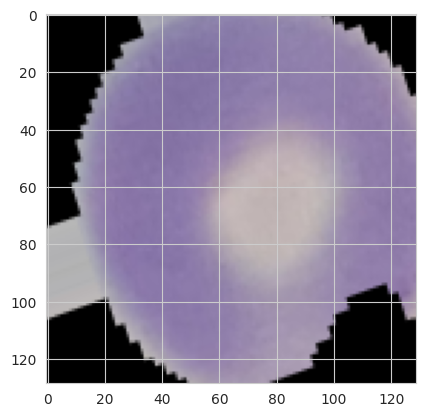

In [51]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 129, 129, 3)


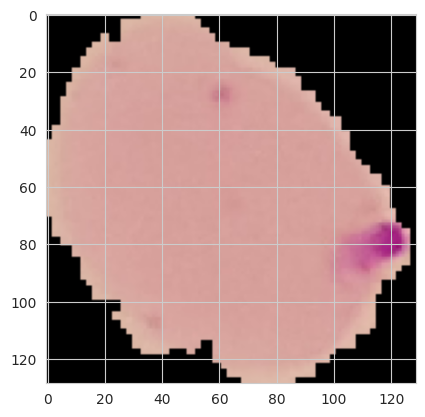

(20, 129, 129, 3)


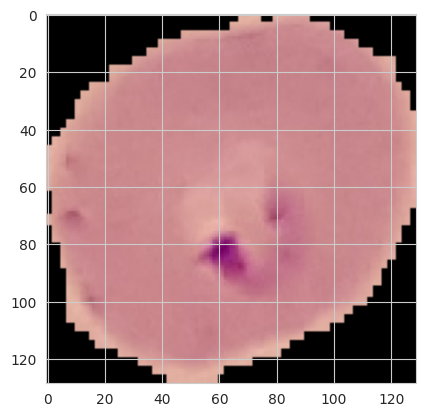

(20, 129, 129, 3)


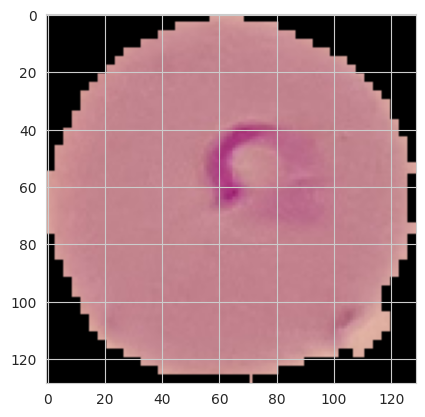

In [52]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 129, 129, 3)


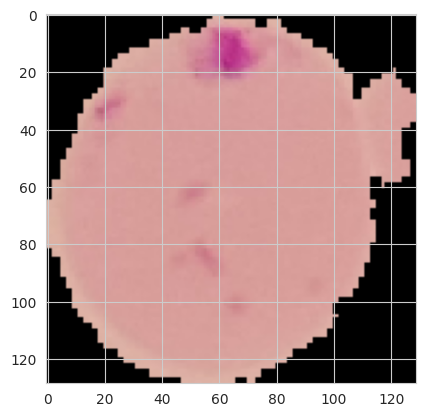

(20, 129, 129, 3)


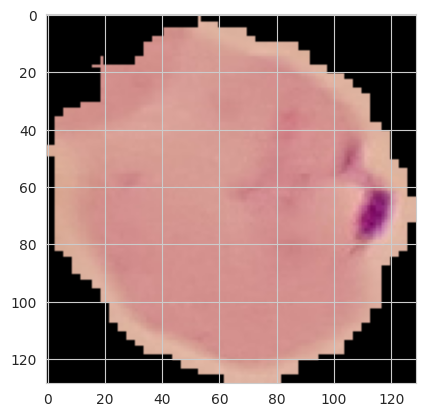

(20, 129, 129, 3)


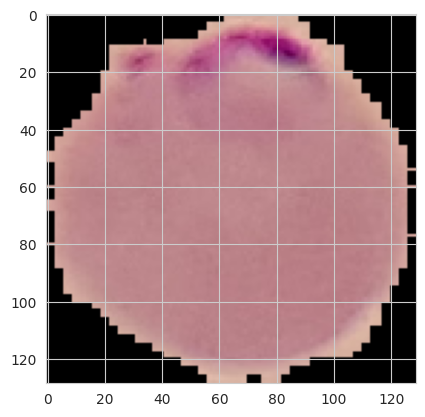

In [53]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [54]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [56]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

* ### Model Summary 

In [57]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 127, 127, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

* ### Early Stopping 

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fit model for model training

In [59]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
395/395 [==============================] - 66s 164ms/step - loss: 0.5081 - accuracy: 0.7635 - val_loss: 0.3167 - val_accuracy: 0.8865
Epoch 2/25
395/395 [==============================] - 79s 200ms/step - loss: 0.2472 - accuracy: 0.9330 - val_loss: 0.1832 - val_accuracy: 0.9619
Epoch 3/25
395/395 [==============================] - 78s 198ms/step - loss: 0.1910 - accuracy: 0.9408 - val_loss: 0.1455 - val_accuracy: 0.9610
Epoch 4/25
395/395 [==============================] - 75s 189ms/step - loss: 0.1830 - accuracy: 0.9480 - val_loss: 0.1192 - val_accuracy: 0.9690
Epoch 5/25
395/395 [==============================] - 71s 180ms/step - loss: 0.1613 - accuracy: 0.9563 - val_loss: 0.1088 - val_accuracy: 0.9681
Epoch 6/25
395/395 [==============================] - 76s 193ms/step - loss: 0.1609 - accuracy: 0.9515 - val_loss: 0.0988 - val_accuracy: 0.9707
Epoch 7/25
395/395 [==============================] - 73s 184ms/step - loss: 0.1522 - accuracy: 0.9561 - val_loss: 0.1018 - val_ac

## Save model

In [60]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performace

---

## Model learning curve

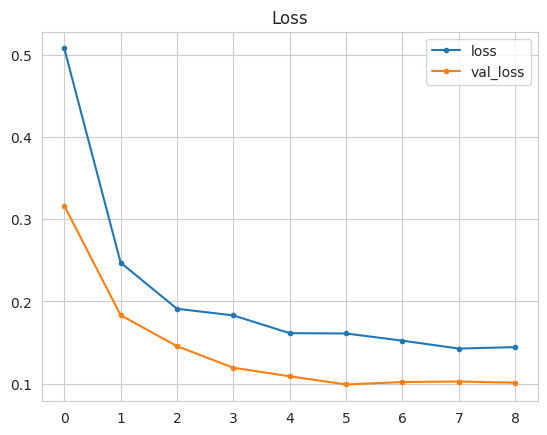

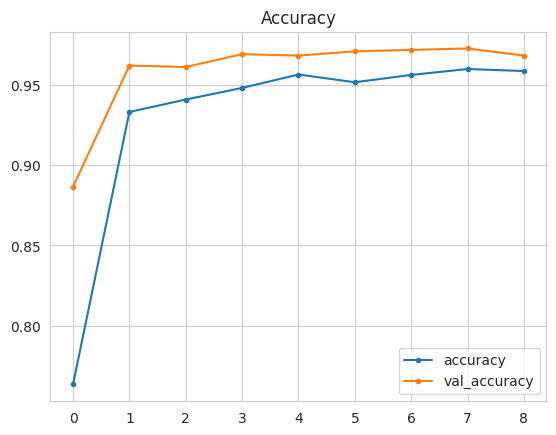

In [61]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [62]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [63]:
evaluation = model.evaluate(test_set)


113/113 [==============================] - 4s 38ms/step - loss: 0.1118 - accuracy: 0.9650


### Save evaluation pickle

In [64]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


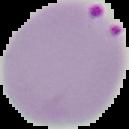

In [65]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [66]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [67]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.9999934004226816
Parasitized


---

# Push files to Repo

## Push generated/new files from this Session to GitHub repo

* .gitignore

In [68]:
!cat .gitignore

inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
kaggle.json
*.ipynb



* Git status

In [69]:
!git status

On branch deployment_v1
Your branch is up to date with 'origin/deployment_v1'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_155.png
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141428_cell_137.png
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141504_cell_149.png
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141504_cell_152.png
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142109_cell_134.png
	deleted:    inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142109_cell_137.png
	deleted:    inputs/malaria_dataset/cell_images/val

* Git add

In [70]:
!git add .

* Git commit

In [71]:
!git commit -am " Add new plots"

[deployment_v1 16ede160]  Add new plots
 2018 files changed, 2184 insertions(+), 228 deletions(-)
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_135449_cell_136.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_151.png
 delete mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_155.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141341_cell_160.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141428_cell_126.png
 delete mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141428_cell_137.png
 delete mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141504_cell_149.png
 delete mode 100644 inputs/malaria

* Git Push

In [72]:
!git push

Enumerating objects: 1045, done.
Counting objects: 100% (1045/1045), done.
Delta compression using up to 16 threads
Compressing objects: 100% (1020/1020), done.
Writing objects: 100% (1025/1025), 31.42 MiB | 12.00 MiB/s, done.
Total 1025 (delta 5), reused 1004 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/roeszler/Malaria-Detector-2022.git
   55d58460..16ede160  deployment_v1 -> deployment_v1


---